## Import the necessary libraries

In [2]:
# Import the necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from timeit import default_timer as timer
import scipy
from scipy.io import loadmat, savemat
from utils.data_utils_simpler_model import sample_parameter, \
    generate_normal, generate_driving_signal, generate_trajectory, generate_trajectory_alternative_model, \
    generate_trajectory_param_pairs
from utils.plot_utils import plot_trajectories
import json
from src.rnn_models_NLSS_modified import RNN_model, push_model

In [3]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [4]:
#with open('./log/estimate_theta_pfixed/gru_L2_H60_modified_RNN_simpler_model_M50_P500_N200/gru_losses_eps6000.json') as p:
#    plot_data = json.load(p)

with open('./log/estimate_theta_pfixed/gru_L2_H40_modified_RNN_simpler_altmodel_M50_P500_N200/gru_losses_eps6000.json') as p:
    plot_data = json.load(p)
    
with open('./log/estimate_theta_pfixed/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1000_N200/gru_losses_eps3000.json') as p:
    plot_data_P1000 = json.load(p)
    
with open('./log/estimate_theta_pfixed/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P2000_N200/gru_losses_eps3000.json') as p:
    plot_data_P2000 = json.load(p)

with open('./log/estimate_theta_pfixed/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1500_N200/gru_losses_eps3000.json') as p:
    plot_data_P1500 = json.load(p)
    
with open('./log/estimate_theta_pfixed/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P500_N200/gru_losses_eps3000.json') as p:
    plot_data_P500 = json.load(p)
        

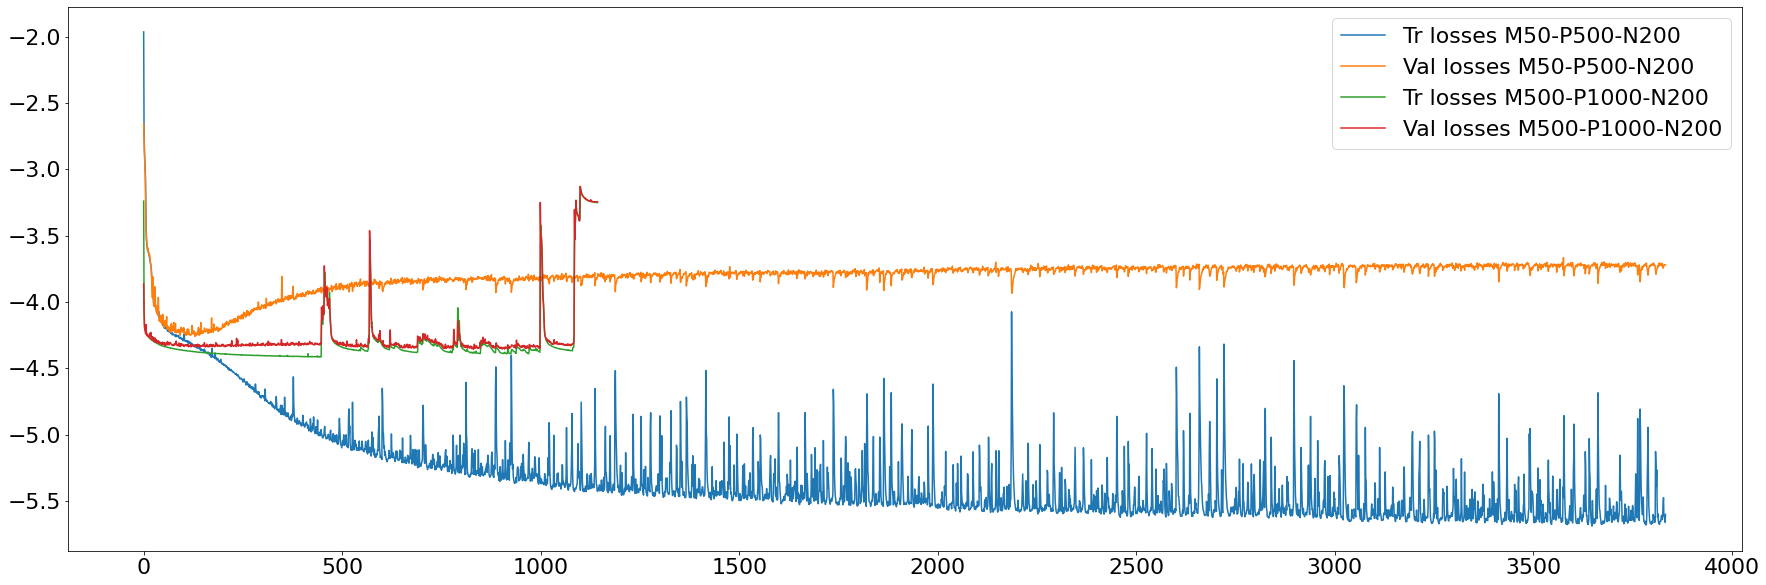

In [5]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30, 10))
plt.plot(np.log(plot_data['tr_losses']))
plt.plot(np.log(plot_data['val_losses']))
plt.plot(np.log(plot_data_P1000['tr_losses']))
plt.plot(np.log(plot_data_P1000['val_losses']))
plt.legend(['Tr losses M50-P500-N200', 'Val losses M50-P500-N200', 'Tr losses M500-P1000-N200', 'Val losses M500-P1000-N200'])
plt.show()

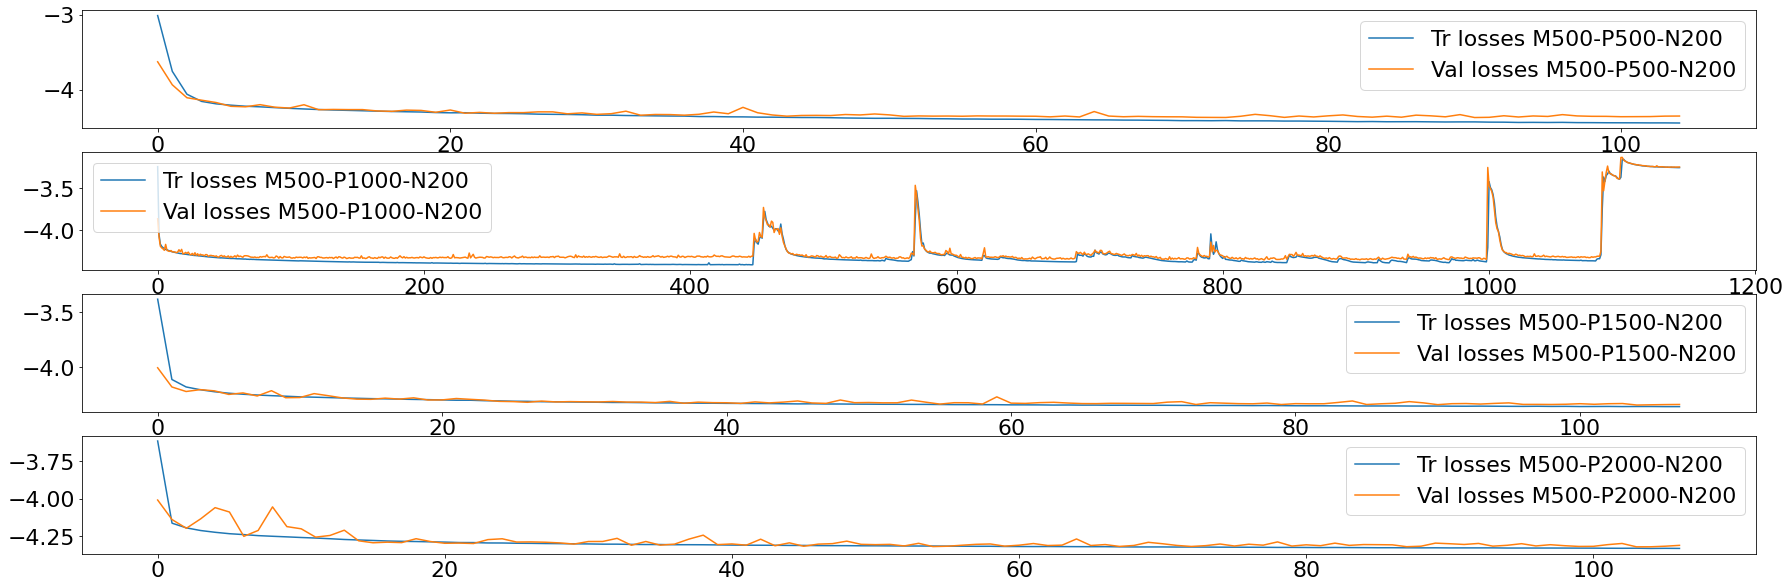

In [6]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30, 10))
plt.subplot(411)
plt.plot(np.log(plot_data_P500['tr_losses']))
plt.plot(np.log(plot_data_P500['val_losses']))
plt.legend(['Tr losses M500-P500-N200', 'Val losses M500-P500-N200'])
plt.subplot(412)
plt.plot(np.log(plot_data_P1000['tr_losses']))
plt.plot(np.log(plot_data_P1000['val_losses']))
plt.legend(['Tr losses M500-P1000-N200', 'Val losses M500-P1000-N200'])
plt.subplot(413)
plt.plot(np.log(plot_data_P1500['tr_losses']))
plt.plot(np.log(plot_data_P1500['val_losses']))
plt.legend(['Tr losses M500-P1500-N200', 'Val losses M500-P1500-N200'])
plt.subplot(414)
plt.plot(np.log(plot_data_P2000['tr_losses']))
plt.plot(np.log(plot_data_P2000['val_losses']))
plt.legend(['Tr losses M500-P2000-N200', 'Val losses M500-P2000-N200'])
plt.show()

In [7]:
# Set parameters for training data generation
N=200
M=100
P=1

In [8]:
# Load the dataset
Z_pM_test_sampled_theta = generate_trajectory_param_pairs(N=N, M=1, P=100, usenorm_flag=0)
#Z_pM_test_sampled_theta = loadmat('evaluation_data/evaluation_ZN_100_variable_samples_pfixed.mat')

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
# Saving the created datasets
#savemat('./evaluation_data/evaluation_ZN_{}_variable_samples_simpler_alt_model.mat'.format(M*P), Z_pM_test_sampled_theta)

In [10]:
def generate_trajectory_fixed_param_pairs(N=1000, M=50, P=5, usenorm_flag=0):

    # Define the parameters of the model
    #N = 1000

    # Plot the trajectory versus sample points
    #num_trajs = 5

    Z_pM = {}
    Z_pM["num_realizations"] = P
    Z_pM["num_trajectories"] = M
    Z_pM_data_lengths = []

    count = 0
    Z_pM_data = []

    for i in range(P):
        
        # Obtain a realization of theta
        #theta_vector = np.array([0.7, 0.8, 1.0, 1.0]).reshape((-1, 1))
        theta_vector = np.array([0.7, 1.0, 0.1, 0.1]).reshape((-1, 1))
        
        for m in range(M): 
            
            # Obtain the trajectory from the recursion
            #Y = generate_trajectory(N=N, theta_vector=theta_vector).reshape((-1, 1))
            Y = generate_trajectory_alternative_model(N=N, theta_vector=theta_vector).reshape((-1, 1))
            # Normalize the data in range [0,1]
            if usenorm_flag == 1:
                Y = normalize(Y, feature_space=(0,1))
            elif usenorm_flag == 0:
                pass
            Z_pM_data.append([theta_vector, Y])
            Z_pM_data_lengths.append(N) 
        
    Z_pM["data"] = np.row_stack(Z_pM_data).astype(np.object)
    #Z_pM["data"] = Z_pM_data
    Z_pM["trajectory_lengths"] = np.vstack(Z_pM_data_lengths)

    return Z_pM

In [11]:
'''
# Starting the recursion
x = np.zeros((N+1,)) # Also includes initial zero value
y = np.zeros((N,))
theta_vector = np.array([0.7, 1.0, 0.1, 0.1]).reshape((-1, 1))
#NOTE: Since theta_5 and theta_6 are modeling variances in this code, 
# for direct comparison with the MATLAB code, the std param input should be
# a square root version
v_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(theta_vector[2]))
e_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(theta_vector[3]))

# Initiating the recursion
for k in range(N):

    # Generate driving noise (which is time varying)
    # Driving noise should be carefully selected as per value of k (start from k=0 or =1)
    u_k = generate_driving_signal(k, a=1.2, add_noise=False)

    # For each instant k, sample v_k, e_k
    v_k = v_k_arr[k]
    e_k = e_k_arr[k]

    # Equation for updating the hidden state
    x[k+1] = theta_vector[0] * (x[k] / ((0.2*x[k])**2 + 1.0))  + u_k + v_k

    # Equation for calculating the output state
    y[k] = theta_vector[1] * (x[k]**2) + e_k
'''

'\n# Starting the recursion\nx = np.zeros((N+1,)) # Also includes initial zero value\ny = np.zeros((N,))\ntheta_vector = np.array([0.7, 1.0, 0.1, 0.1]).reshape((-1, 1))\n#NOTE: Since theta_5 and theta_6 are modeling variances in this code, \n# for direct comparison with the MATLAB code, the std param input should be\n# a square root version\nv_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(theta_vector[2]))\ne_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(theta_vector[3]))\n\n# Initiating the recursion\nfor k in range(N):\n\n    # Generate driving noise (which is time varying)\n    # Driving noise should be carefully selected as per value of k (start from k=0 or =1)\n    u_k = generate_driving_signal(k, a=1.2, add_noise=False)\n\n    # For each instant k, sample v_k, e_k\n    v_k = v_k_arr[k]\n    e_k = e_k_arr[k]\n\n    # Equation for updating the hidden state\n    x[k+1] = theta_vector[0] * (x[k] / ((0.2*x[k])**2 + 1.0))  + u_k + v_k\n\n    # Equation for calculating the output 

In [12]:
'''
generated_traj = {}
generated_traj["y_python"] = y
generated_traj["v_python"] = v_k_arr
generated_traj["e_python"] = e_k_arr
savemat('evaluation_data/verifying_trajectory.mat', generated_traj)
'''

'\ngenerated_traj = {}\ngenerated_traj["y_python"] = y\ngenerated_traj["v_python"] = v_k_arr\ngenerated_traj["e_python"] = e_k_arr\nsavemat(\'evaluation_data/verifying_trajectory.mat\', generated_traj)\n'

In [13]:
#Z_pM_test_fixed_theta = generate_trajectory_fixed_param_pairs(N=N, M=M, P=P, usenorm_flag=0)
Z_pM_test_fixed_theta = loadmat('evaluation_data/simpler_model/current_version/evaluation_ZN_100_fixed_samples_simpler_alt_model.mat')

In [14]:
#savemat('evaluation_data/evaluation_ZN_{}_fixed_samples_simpler_alt_model.mat'.format(M*P), Z_pM_test_fixed_theta)

<Figure size 2160x720 with 0 Axes>

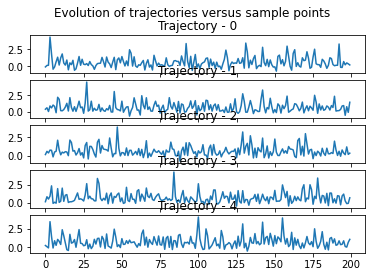

In [15]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(30, 10))
plot_trajectories(Z_pM=Z_pM_test_fixed_theta, nrows=int(5), ncols=1)

In [16]:
# Importing the model configuration options
with open("./config/configurations_simpler_model.json") as f:
    options = json.load(f)

### Load results from MATLAB model

In [17]:
res_matlab_method = loadmat('matlab_results/results_ML_fixed_results_simpler_model.mat')
threshold = 1.0 # MSE Threshold for selecting 'good' samples 
mask = res_matlab_method['res_sampled_theta']['msevec'][-1][-1] <= threshold
default_mask = np.array([True]*int(M*P))

In [18]:
sum(mask)

array([92])

In [19]:
len(default_mask)

100

## Analysis for GRU model

In [20]:
# Prediction using trained model
def compute_loss_using_saved_model(actual_data, actual_theta_vectors, best_saved_model, model_type, device, criterion=None, mask=None):
    te_running_loss = 0.0
    test_loss_epoch_sum = 0.0
    mask = mask.flatten()
    #mask = [True, True, False, False, True, True, True]
    with torch.no_grad():

        X_test = Variable(torch.from_numpy(actual_data), requires_grad=False).type(torch.FloatTensor).to("cpu")
        prediction_theta_vectors = best_saved_model.forward(X_test)
        print(prediction_theta_vectors[:10, :])
        prediction_theta_vectors = torch.cat((prediction_theta_vectors[:, :-2], 
                                              torch.square(prediction_theta_vectors[:, -2:])), dim=1)
        
        loss = criterion(prediction_theta_vectors[mask, :], torch.from_numpy(actual_theta_vectors.squeeze(2)[mask, :]))
        print("Loss for saved {} model is : {}".format(model_type, loss))
        print("-"*100)
    
    return loss, prediction_theta_vectors

In [21]:
# Define a function for loading model
def load_model_from_weights(model_type, model_file, device):
    #Load and Set model in evaluation mode
    model = RNN_model(**options[model_type]).to(device)
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    model = push_model(nets=model, device=device)
    model.eval()
    return model

In [22]:
np.set_printoptions(suppress=True)

In [23]:
def evaluate_using_saved_RNN_model(Z_pM_test, best_saved_model_file, model_type='gru', device='cpu', criterion=None, mask=None, sampled=False, savefig_path=None):
    
    # Define some criterion for evaluation if not specified already
    if criterion is None:
        criterion = nn.MSELoss(reduction='mean')
    
    # Load the saved model
    best_saved_model = load_model_from_weights(model_type, 
                                               best_saved_model_file, 
                                               device)
    
    # Print some shapes for sanity check
    # Print out some shapes for sanity check
    print(Z_pM_test["data"][0][1].shape, 
          type(Z_pM_test["data"][0][1]), 
          Z_pM_test["data"][0][0].shape)
    
    # Get the data and targets separately as a numpy array
    actual_data = np.row_stack([np.expand_dims(Z_pM_test["data"][i][1], axis=0) for i in range(len(Z_pM_test["data"]))])
    actual_theta_vectors = np.row_stack([np.expand_dims(Z_pM_test["data"][i][0], axis=0) for i in range(len(Z_pM_test["data"]))])
    
    # Print shape of inputs and targets
    print("Input shape:{}, Targets shape:{}".format(actual_data.shape, actual_theta_vectors.shape))
    
    # Get loss, predictions
    starttime = timer()
    loss, predicted_theta_vectors = compute_loss_using_saved_model(actual_data, 
                                                                   actual_theta_vectors, 
                                                                   best_saved_model, 
                                                                   model_type, 
                                                                   device,
                                                                   criterion,
                                                                   mask=mask)
    
    endtime = timer()
    elapsed_time = endtime - starttime # Measure time elapsed in seconds
    
    print("Inference time: {} secs".format(elapsed_time))
    print("-"*100)
    print("Mean")
    print(torch.mean(predicted_theta_vectors, axis=0))
    print("-"*100)
    print("Covariance matrix")
    print(np.cov(predicted_theta_vectors.numpy(), rowvar=False))
    #plt.figure(figsize=(20, 10))
    #plt.imshow(np.cov(predicted_theta_vectors.numpy(), rowvar=False), vmin=0, vmax=1, interpolation='nearest')
    #plt.title('Covariance matrix for the 5-parameter results')
    print("-"*100)
    print("Prediction results")
    # Check one of the predictions
    print(np.c_[predicted_theta_vectors[:10, :], actual_theta_vectors.squeeze(2)[:10, :]])
    
    # Prediction boxplots
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10, 5))
    plt.rcParams["font.family"] = "serif"
    if sampled == False:
        # theta_1
        plt.subplot(221)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), sym='r+', showmeans=True)
        plt.axhline(actual_theta_vectors[0, 0], c='b')
        plt.title(r'$\theta_1$')
        #plt.xticks(np.arange(0.3, 0.7, 5), str(np.arange(0.3, 0.7, 5)))

        # theta_2
        plt.subplot(222)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), sym='r+', showmeans=True)
        plt.axhline(actual_theta_vectors[0, 1], c='b')
        plt.title(r'$\theta_2$')

        # theta_5
        plt.subplot(223)
        plt.boxplot(predicted_theta_vectors[:, 2].numpy(), sym='r+', showmeans=True)
        plt.axhline(actual_theta_vectors[0, 2], c='b')
        plt.title(r'$\theta_3$')

        # theta_6
        plt.subplot(224)
        plt.boxplot(predicted_theta_vectors[:, 3].numpy(), sym='r+', showmeans=True)
        plt.axhline(actual_theta_vectors[0, 3], c='b')
        plt.title(r'$\theta_4$')

        # Multiple box plots on one Axes
        # Prediction boxplots
        #plt.rcParams["font.family"] = "serif"
        #plt.rcParams.update({'font.size': 20})
        #plt.figure(figsize=(12, 5))
        green_diamond = dict(markerfacecolor='r', marker='D')
        meanprops = dict(linewidth=1.5, color='green', linestyle='solid')
        medianprops = dict(linewidth=2.0, color='orange', linestyle='solid')
        fig, ax = plt.subplots(figsize=(12, 7))
        print(predicted_theta_vectors.shape)
        ax.boxplot(predicted_theta_vectors.numpy(), showmeans=True, flierprops=green_diamond, notch=False, vert=False,
                                                meanline=True, meanprops=meanprops, medianprops=medianprops)
        ax.set_yticks([y + 1 for y in range(predicted_theta_vectors.shape[1])])
        ax.set_yticklabels([r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$'])
        ax.set_xticks(np.linspace(0, 1.3, 10).tolist())
        ax.set_xticklabels(np.linspace(0, 1.3, 10).round(1).tolist())
        ax.grid(True, linestyle='--', linewidth=1)
        plt.show()

    else:
        # theta_1
        plt.subplot(231)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), sym='r', showmeans=True)
        plt.axhline(np.mean(actual_theta_vectors, axis=0)[0], c='b')
        #plt.xticks(np.arange(0.3, 0.7, 5), str(np.arange(0.3, 0.7, 5)))
        plt.title(r'$\theta_1$')

        # theta_2
        plt.subplot(232)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), sym='r', showmeans=True)
        plt.axhline(np.mean(actual_theta_vectors, axis=0)[1], c='b')
        plt.title(r'$\theta_2$')
        
        # theta_5
        plt.subplot(233)
        plt.boxplot(predicted_theta_vectors[:, 2].numpy(), sym='r', showmeans=True)
        plt.axhline(np.mean(actual_theta_vectors, axis=0)[2], c='b')
        plt.title(r'$\theta_3$')

        # theta_6
        plt.subplot(234)
        plt.boxplot(predicted_theta_vectors[:, 3].numpy(), sym='r', showmeans=True)
        plt.axhline(np.mean(actual_theta_vectors, axis=0)[3], c='b')
        plt.title(r'$\theta_4$')
    
    if not savefig_path is None:
        plt.savefig(savefig_path)
        
    return loss, predicted_theta_vectors

### Evaluating the results for GRU model

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M50_P500_N200/gru_usenorm_0_ckpt_epoch_3834_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.6719, 1.0713, 0.2484, 0.3909],
        [0.7619, 1.0591, 0.2877, 0.4033],
        [0.7285, 1.0515, 0.3021, 0.3769],
        [0.6507, 0.7578, 0.4223, 0.3050],
        [0.6711, 1.0619, 0.3024, 0.3402],
        [0.8151, 1.0442, 0.2031, 0.3610],
        [0.6690, 0.8676, 0.3900, 0.3234],
        [0.7246, 1.0340, 0.3514, 0.2344],
        [0.6464, 1.0165, 0.3150, 0.3246],
        [0.7220, 0.9165, 0.2807, 0.3331]])
Loss for saved gru model is : 0.0044941943846942885
----------------------------------------------------------------------------------------------------
Inference time: 0.11535229100002198 secs
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7249, 1.0312, 0.1023, 0.1067])
--------------------------

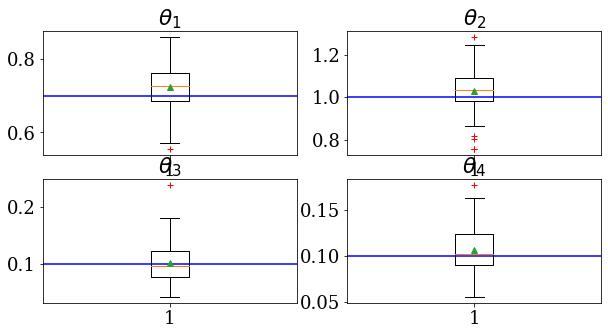

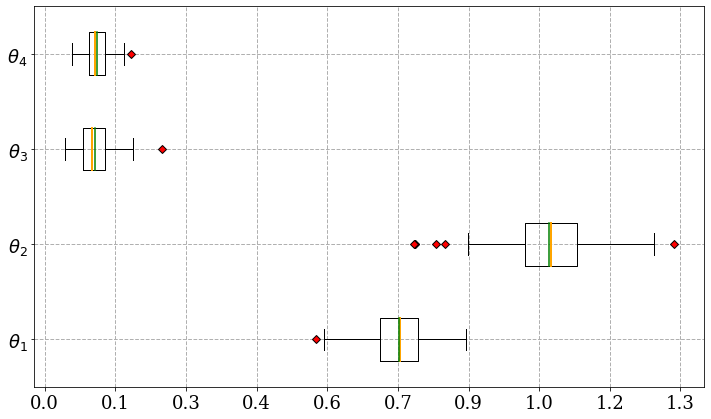

In [24]:
#best_model_gru_model = 'models/gru_L2_H60_modified_RNN_simpler_model_M50_P500_N200/gru_usenorm_0_ckpt_epoch_1011_best.pt'
best_model_gru_model = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M50_P500_N200/gru_usenorm_0_ckpt_epoch_3834_best.pt'
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model))
gru_best_model_loss, gru_best_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

#trained_gru_model = 'models/gru_L2_H60_pfixed_results/gru_usenorm_0_ckpt_epoch_3000.pt'
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
#print("Evaluate for model:{}".format(trained_gru_model))
#gru_model_loss, gru_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_sampled_theta,
#                                                                                 best_saved_model_file=trained_gru_model,
#                                                                                 model_type='gru',
#                                                                                 device='cpu',
#                                                                                 criterion=nn.MSELoss(reduction='mean'),
#                                                                                 mask=mask)

## From the experiments it is clear that using greater amount of data helps the algorithm to go very close and almost slightly better than EMPS. Also by tuning it is found that min_delta = 1e-2 works best as an early stopping criterion. Further decreasing min_delta = 1e-3 is not suitable for convergence

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1000_N200/gru_usenorm_0_ckpt_epoch_105_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.6748, 0.9775, 0.2797, 0.4147],
        [0.6893, 0.9906, 0.3283, 0.3797],
        [0.6754, 0.9568, 0.3341, 0.3889],
        [0.7223, 0.9210, 0.3107, 0.3634],
        [0.6879, 1.0462, 0.3059, 0.3529],
        [0.6525, 0.8908, 0.3292, 0.3525],
        [0.6928, 0.7768, 0.4200, 0.3094],
        [0.7436, 1.0858, 0.2900, 0.2674],
        [0.6368, 1.0183, 0.3157, 0.3020],
        [0.7449, 1.0237, 0.2697, 0.3268]])
Loss for saved gru model is : 0.0032631084182169158
----------------------------------------------------------------------------------------------------
Inference time: 0.09049674999999979 secs
----------------------------------------------------------------------------------------------------
Mean
tensor([0.6904, 0.9963, 0.1049, 0.1107])
-------------------------

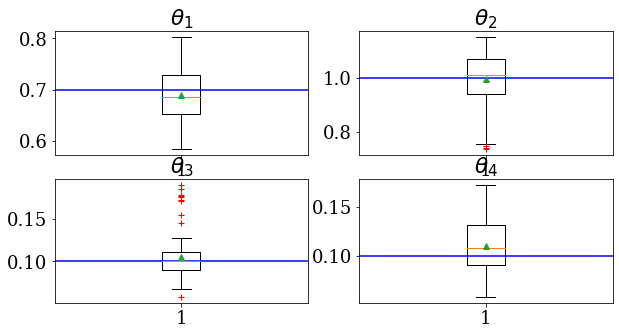

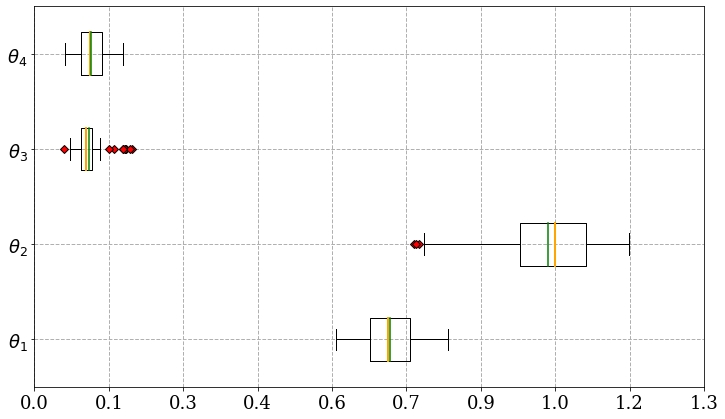

In [25]:
#best_model_gru_model = 'models/gru_L2_H60_modified_RNN_simpler_model_M50_P500_N200/gru_usenorm_0_ckpt_epoch_1011_best.pt'
best_model_gru_model_P1000 = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1000_N200/gru_usenorm_0_ckpt_epoch_105_best.pt' #1e-2 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_P1000))
gru_best_model_loss_P1000, gru_best_model_predicted_theta_vectors_P1000 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_P1000,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

#trained_gru_model = 'models/gru_L2_H60_pfixed_results/gru_usenorm_0_ckpt_epoch_3000.pt'
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
#print("Evaluate for model:{}".format(trained_gru_model))
#gru_model_loss, gru_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_sampled_theta,
#                                                                                 best_saved_model_file=trained_gru_model,
#                                                                                 model_type='gru',
#                                                                                 device='cpu',
#                                                                                 criterion=nn.MSELoss(reduction='mean'),
#                                                                                 mask=mask)

## Using a min_delta of 5e-3, improves results compared to 1e-3 but still a bit of overfitting

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1000_N200/gru_usenorm_0_ckpt_epoch_113_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.6900, 1.0685, 0.2775, 0.4048],
        [0.7067, 1.0046, 0.3275, 0.4001],
        [0.6872, 0.8837, 0.3696, 0.3921],
        [0.7030, 0.8453, 0.3314, 0.3569],
        [0.7130, 0.9960, 0.3339, 0.3630],
        [0.6222, 0.8278, 0.3361, 0.3582],
        [0.7131, 0.8150, 0.3896, 0.3393],
        [0.7154, 0.9374, 0.3539, 0.3028],
        [0.6850, 0.9135, 0.3278, 0.3222],
        [0.7441, 0.9092, 0.3111, 0.3333]])
Loss for saved gru model is : 0.004111081865663032
----------------------------------------------------------------------------------------------------
Inference time: 0.09059300000001258 secs
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7074, 0.9474, 0.1163, 0.1209])
--------------------------

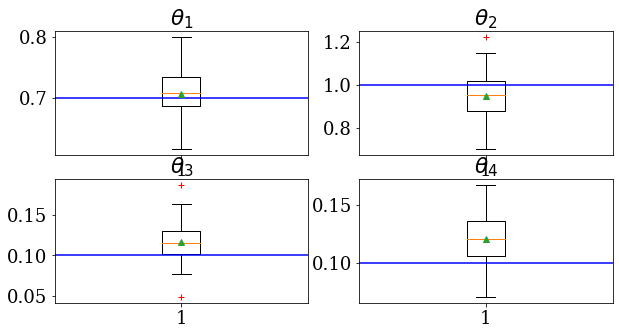

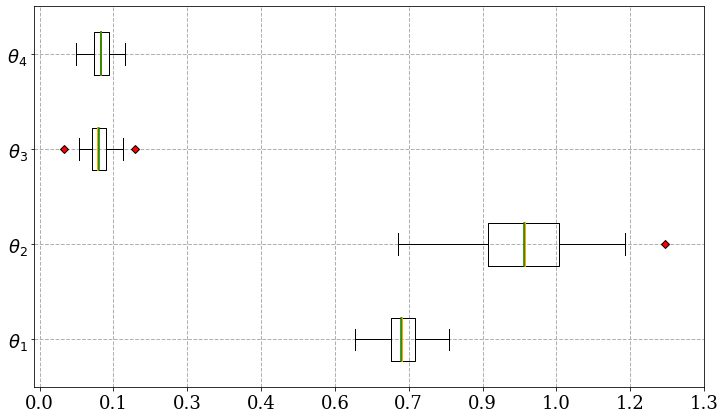

In [26]:
best_model_gru_model_large_dataset = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1000_N200/gru_usenorm_0_ckpt_epoch_113_best.pt' #5e-3 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_large_dataset))
gru_best_model_loss_large_dataset, gru_best_model_predicted_theta_vectors_large_dataset = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_large_dataset,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

## This is experimenting the same using a min_delta = 1e-2, but using an even larger dataset consisting of P=2000, M=500, N=200 samples during training

### Results for $\theta_{\circ, fixed}$:

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_107_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.6756, 1.0366, 0.2509, 0.3596],
        [0.7188, 0.9882, 0.2946, 0.3726],
        [0.6975, 0.9121, 0.3253, 0.3656],
        [0.7068, 0.8946, 0.2836, 0.3293],
        [0.7015, 1.0115, 0.2894, 0.3191],
        [0.6441, 0.8903, 0.2909, 0.3178],
        [0.6807, 0.8488, 0.3839, 0.2999],
        [0.7339, 1.0008, 0.2842, 0.2653],
        [0.6624, 0.9375, 0.3046, 0.2917],
        [0.7439, 0.9582, 0.2653, 0.3021]])
Loss for saved gru model is : 0.0026526499289648165
----------------------------------------------------------------------------------------------------
Inference time: 0.08650416599999744 secs
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7027, 0.9659, 0.0992, 0.0987])
-------------------------

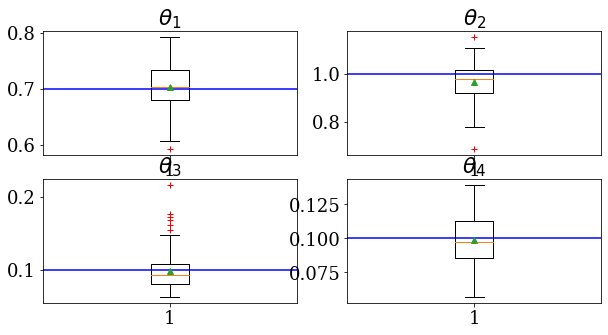

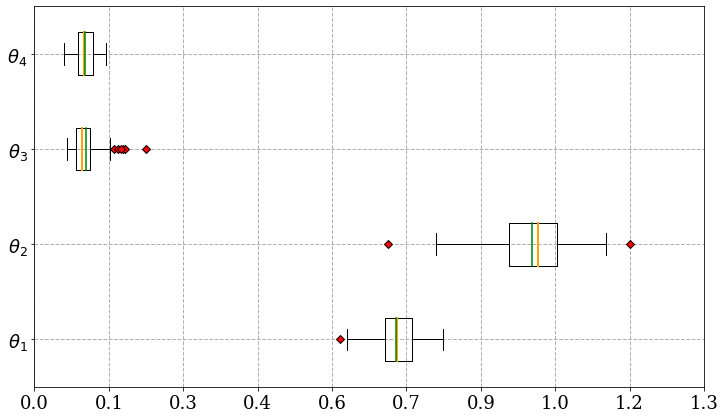

<Figure size 432x288 with 0 Axes>

In [27]:
best_model_gru_model_P2000 = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_107_best.pt' #5e-3 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_P2000))
gru_best_model_loss_P2000, gru_best_model_predicted_theta_vectors_P2000 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_P2000,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask,
                                                                                             savefig_path='./result_figures/boxplot_simplermodel_M500_P2000_withgrid.pdf')

## P=1500, M=500, N=200

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1500_N200/gru_usenorm_0_ckpt_epoch_108_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.6648, 1.0258, 0.2936, 0.3587],
        [0.7252, 1.0119, 0.3140, 0.3561],
        [0.6698, 1.0008, 0.3304, 0.3692],
        [0.7188, 0.9188, 0.3035, 0.3370],
        [0.7369, 1.0490, 0.3024, 0.3245],
        [0.6648, 0.8922, 0.3181, 0.3249],
        [0.6475, 0.8715, 0.3975, 0.3042],
        [0.7432, 1.0355, 0.3022, 0.2417],
        [0.6830, 1.0255, 0.3013, 0.3061],
        [0.7526, 0.9999, 0.2797, 0.2877]])
Loss for saved gru model is : 0.0029340852416297734
----------------------------------------------------------------------------------------------------
Inference time: 0.09144695900005217 secs
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7155, 1.0183, 0.1024, 0.1022])
-------------------------

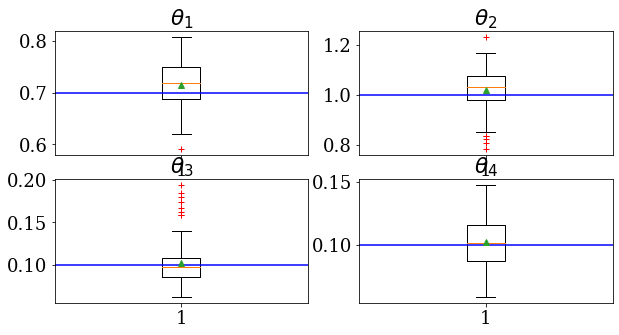

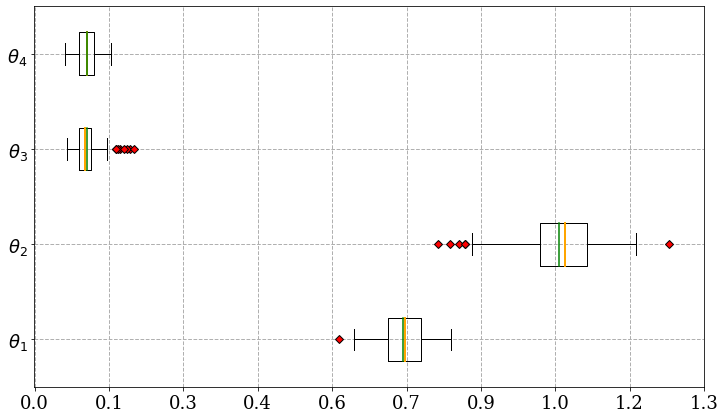

In [28]:
best_model_gru_model_P1500 = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P1500_N200/gru_usenorm_0_ckpt_epoch_108_best.pt' #1e-2 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_P1500))
gru_best_model_loss_P1500, gru_best_model_predicted_theta_vectors_P1500 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_P1500,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

## P=500, M=500, N=200

Evaluate for model:models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P500_N200/gru_usenorm_0_ckpt_epoch_105_best.pt
(200, 1) <class 'numpy.ndarray'> (4, 1)
Input shape:(100, 200, 1), Targets shape:(100, 4, 1)
tensor([[0.7162, 1.1195, 0.2820, 0.3841],
        [0.7371, 1.1436, 0.3099, 0.3738],
        [0.6308, 0.8047, 0.4240, 0.3573],
        [0.6824, 0.7827, 0.3701, 0.3342],
        [0.7141, 1.1174, 0.3383, 0.3210],
        [0.5969, 0.7319, 0.4084, 0.3206],
        [0.6499, 0.7474, 0.4442, 0.2939],
        [0.7249, 1.1578, 0.3130, 0.2447],
        [0.6521, 0.9220, 0.3692, 0.2978],
        [0.7623, 0.9595, 0.2827, 0.3051]])
Loss for saved gru model is : 0.008797140324663144
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([0.6877, 0.9828, 0.1319, 0.0990])
--------------------------------------------------------------------

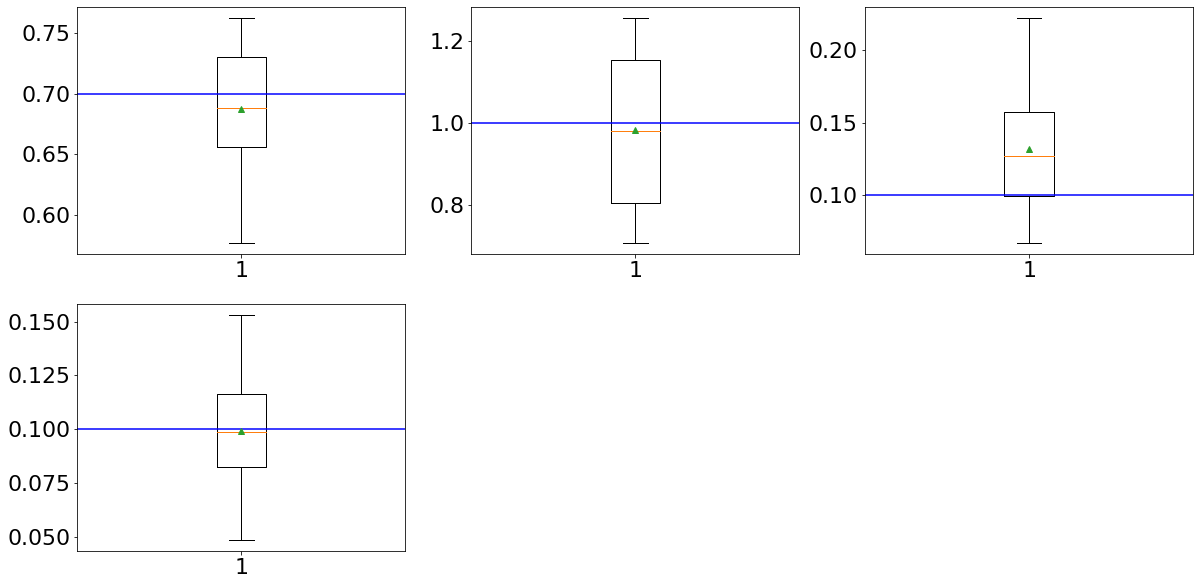

In [32]:
best_model_gru_model_P500 = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P500_N200/gru_usenorm_0_ckpt_epoch_105_best.pt' #1e-2 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_P500))
gru_best_model_loss_P500, gru_best_model_predicted_theta_vectors_P500 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_P500,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

### Results for $\theta_{sampled}$:

In [ ]:
best_model_gru_model_larger_dataset = 'models/gru_L2_H40_modified_RNN_simpler_altmodel_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_107_best.pt' #5e-3 delta
#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_larger_dataset))
gru_best_model_loss_larger_dataset_sampled, gru_best_model_predicted_theta_vectors_larger_dataset = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_larger_dataset,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)